# Random Forest Workload Detection - Results Visualization

This notebook/script visualizes results from the random forest pipeline.

To generate results, first run:
    python run_pipeline.py

## 0. Setup/Imports

In [6]:
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration
OUTPUT_DIR = Path("model_output")
FIG_DIR = Path("figs")
FIG_DIR.mkdir(exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("colorblind")


# %% Helper Functions

def load_results(json_filename):
    """Load results from JSON file."""
    json_path = OUTPUT_DIR / json_filename
    if not json_path.exists():
        print(f"⚠️  File not found: {json_filename}")
        return None
    
    with open(json_path, "r") as f:
        return json.load(f)


def extract_metrics(results, metric_prefix="test_bal_acc"):
    """Extract mean and std for a metric from results."""
    if results is None:
        return np.nan, np.nan
    
    metrics = results.get("metrics", {})
    mean = metrics.get(f"{metric_prefix}_mean", 0) * 100.0
    std = metrics.get(f"{metric_prefix}_std", 0) * 100.0
    
    return mean, std


def format_metric(mean, std):
    """Format metric as 'mean ± std'."""
    if np.isnan(mean):
        return "N/A"
    if std == 0:
        return f"{mean:.1f}%"
    return f"{mean:.1f}% ± {std:.1f}%"


def plot_confusion_matrix(results, title, output_path, labels=None):
    """Plot confusion matrix from results."""
    if results is None:
        print(f"⚠️  Cannot plot: {title}")
        return
    
    if labels is None:
        labels = ["L", "M", "H"]
    
    cm = np.array(results["confusion_matrix"])
    
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={"label": "Percentage (%)"},
        ax=ax
    )
    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, format="svg")
    plt.close()
    
    print(f"✓ Saved: {output_path}")


# %% Check Pipeline Status

def check_pipeline_status():
    """Check which experiments have been completed."""
    if not OUTPUT_DIR.exists():
        print("⚠️  Output directory not found. Please run the pipeline first:")
        print("   python run_pipeline.py")
        return False
    
    json_files = list(OUTPUT_DIR.glob("*.json"))
    
    if not json_files:
        print("⚠️  No results found. Please run the pipeline first:")
        print("   python run_pipeline.py")
        return False
    
    print(f"✓ Found {len(json_files)} result files")
    return True


if not check_pipeline_status():
    print("\nExiting. Run pipeline first.")
    exit()


✓ Found 19 result files


## 1. Feature Type Comparisons


PROCRUSTES VS NONE COMPARISON (LINEAR / RQA / COMBINED)


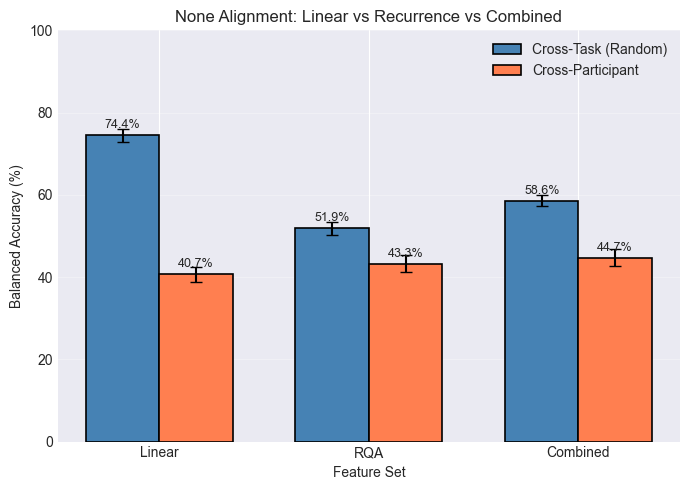

✓ Saved: figs/comparison/none_feature_comparison.svg

None Alignment Results:
Feature      Random                    Participant              
-----------------------------------------------------------------
linear       74.4% ± 1.5%              40.7% ± 1.8%             
rqa          51.9% ± 1.6%              43.3% ± 2.1%             
combined     58.6% ± 1.4%              44.7% ± 2.0%             




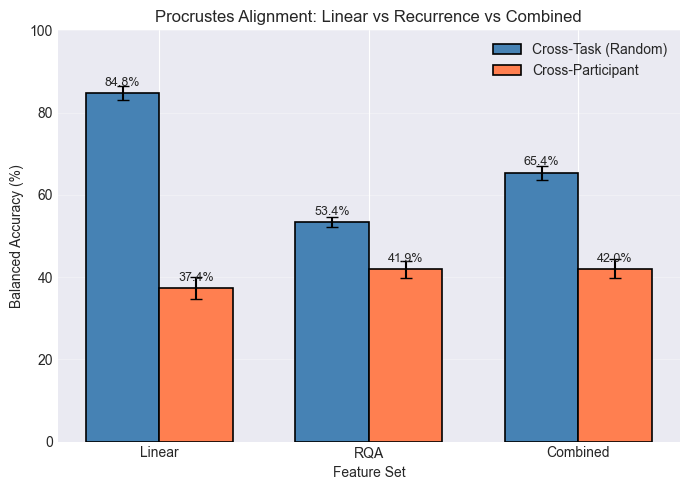

✓ Saved: figs/comparison/procrustes_feature_comparison.svg

Procrustes Alignment Results:
Feature      Random                    Participant              
-----------------------------------------------------------------
linear       84.8% ± 1.8%              37.4% ± 2.7%             
rqa          53.4% ± 1.3%              41.9% ± 2.1%             
combined     65.4% ± 1.7%              42.0% ± 2.3%             




In [12]:
print("\n" + "="*80)
print("PROCRUSTES VS NONE COMPARISON (LINEAR / RQA / COMBINED)")
print("="*80)

compare_dir = FIG_DIR / "comparison"
compare_dir.mkdir(exist_ok=True)

# ============================================================
# DEFINE EXPERIMENT FILES
# ============================================================

experiments = {
    "None": {
        "linear": {
            "random": "linear_none_random.json",
            "participant": "linear_none_participant.json",
        },
        "rqa": {
            "random": "rqa_none_random.json",
            "participant": "rqa_none_participant.json",
        },
        "combined": {
            "random": "combined_none_random.json",
            "participant": "combined_none_participant.json",
        },
    },
    "Procrustes": {
        "linear": {
            "random": "linear_procrustes_random.json",
            "participant": "linear_procrustes_participant.json",
        },
        "rqa": {
            "random": "rqa_procrustes_random.json",
            "participant": "rqa_procrustes_participant.json",
        },
        "combined": {
            "random": "combined_procrustes_random.json",
            "participant": "combined_procrustes_participant.json",
        },
    },
}

# ============================================================
# HELPER FUNCTION TO BUILD FIGURE
# ============================================================

def plot_feature_comparison(alignment_name, data_map):
    features = list(data_map.keys())
    random_means, random_stds = [], []
    participant_means, participant_stds = [], []

    for feat in features:
        rand_results = load_results(data_map[feat]["random"])
        rand_mean, rand_std = extract_metrics(rand_results)
        random_means.append(rand_mean)
        random_stds.append(rand_std)

        part_results = load_results(data_map[feat]["participant"])
        part_mean, part_std = extract_metrics(part_results)
        participant_means.append(part_mean)
        participant_stds.append(part_std)

    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 5))

    bars1 = ax.bar(
        x - width/2, random_means, width,
        label="Cross-Task (Random)",
        yerr=random_stds, capsize=4,
        color="steelblue", edgecolor="black", linewidth=1.2,
    )

    bars2 = ax.bar(
        x + width/2, participant_means, width,
        label="Cross-Participant",
        yerr=participant_stds, capsize=4,
        color="coral", edgecolor="black", linewidth=1.2,
    )

    # Annotate bars
    for bars, means in [(bars1, random_means), (bars2, participant_means)]:
        for bar, mean in zip(bars, means):
            if not np.isnan(mean):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 1,
                    f"{mean:.1f}%",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                )

    ax.set_ylabel("Balanced Accuracy (%)")
    ax.set_xlabel("Feature Set")
    ax.set_title(f"{alignment_name} Alignment: Linear vs Recurrence vs Combined")
    ax.set_xticks(x)
    ax.set_xticklabels(["Linear", "RQA", "Combined"])
    ax.set_ylim(0, 100)
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    out_path = compare_dir / f"{alignment_name.lower()}_feature_comparison.svg"
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"✓ Saved: {out_path}")

    # Print small table
    print(f"\n{alignment_name} Alignment Results:")
    print(f"{'Feature':<12} {'Random':<25} {'Participant':<25}")
    print("-" * 65)
    for feat, rm, rs, pm, ps in zip(features, random_means, random_stds, participant_means, participant_stds):
        print(f"{feat:<12} {format_metric(rm, rs):<25} {format_metric(pm, ps):<25}")
    print("\n")


# ============================================================
# PLOT BOTH ALIGNMENTS
# ============================================================
plot_feature_comparison("None", experiments["None"])
plot_feature_comparison("Procrustes", experiments["Procrustes"])


## 2. Performance Metrics

In [10]:
print("\n" + "="*80)
print("PERFORMANCE METRICS")
print("="*80)

perf_dir = FIG_DIR / "performance"
perf_dir.mkdir(exist_ok=True)

# Load performance metric results
perf_random = load_results("performance_random.json")
perf_participant = load_results("performance_participant.json")

# Extract metrics
perf_rand_mean, perf_rand_std = extract_metrics(perf_random)
perf_part_mean, perf_part_std = extract_metrics(perf_participant)

print(f"Performance Metrics Only:")
print(f"  Cross-Task:        {format_metric(perf_rand_mean, perf_rand_std)}")
print(f"  Cross-Participant: {format_metric(perf_part_mean, perf_part_std)}")

# Plot confusion matrices for performance
plot_confusion_matrix(
    perf_random, 
    "Performance Metrics - Cross-Task",
    perf_dir / "cm_performance_random.svg"
)
plot_confusion_matrix(
    perf_participant,
    "Performance Metrics - Cross-Participant", 
    perf_dir / "cm_performance_participant.svg"
)


PERFORMANCE METRICS
Performance Metrics Only:
  Cross-Task:        55.0% ± 1.7%
  Cross-Participant: 52.1% ± 2.4%
✓ Saved: figs/performance/cm_performance_random.svg
✓ Saved: figs/performance/cm_performance_participant.svg


## 3. Learning Curves

In [15]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print("\n" + "="*80)
print("LEARNING CURVES — NONE VS PROCRUSTES")
print("="*80)

lc_dir = FIG_DIR / "learning_curves"
lc_dir.mkdir(parents=True, exist_ok=True)

def load_learning_curve(json_path):
    """Load learning-curve results JSON -> (minutes, means, ses)."""
    try:
        with open(json_path, "r") as f:
            data = json.load(f)
    except Exception as e:
        print(f"⚠️  Failed to read {json_path.name}: {e}")
        return None

    minutes = data.get("minutes", [])
    lc_results = data.get("results", {})

    xs, means, ses = [], [], []
    for m in minutes:
        vals = lc_results.get(str(m), {}).get("BalancedAcc", [])
        if not vals:
            continue
        vals = np.asarray(vals, dtype=float)
        mu = vals.mean() * 100.0
        sd = vals.std(ddof=1) * 100.0 if vals.size > 1 else 0.0
        se = (sd / np.sqrt(vals.size)) if vals.size > 1 else 0.0
        xs.append(m); means.append(mu); ses.append(se)

    if not xs:
        return None

    order = np.argsort(xs)
    return np.asarray(xs)[order], np.asarray(means)[order], np.asarray(ses)[order]


def plot_grouped_learning_curves(norm_type, json_files, output_path):
    """Plot multiple LC lines (one figure per normalization)."""
    if not json_files:
        print(f"⚠️  No JSONs for {norm_type}")
        return

    fig, ax = plt.subplots(figsize=(9, 6))

    for json_path in json_files:
        curve = load_learning_curve(json_path)
        if curve is None:
            print(f"⚠️  No valid data in {json_path.name}")
            continue
        xs, means, ses = curve
        ci = 1.96 * ses
        label = json_path.stem.replace("lc_", "").replace(norm_type.lower() + "_", "")
        label = label.replace("_", " ").title()

        ax.fill_between(xs, means - ci, means + ci, alpha=0.1)
        ax.plot(xs, means, marker="o", linewidth=2, label=label)

        for x, y in zip(xs, means):
            ax.text(x, y + 1, f"{y:.1f}%", ha="center", va="bottom", fontsize=8)

    ax.set_title(f"Learning Curves — {norm_type} Alignment", fontsize=13, fontweight="bold")
    ax.set_xlabel("Minutes of Experimental Data Added to Training")
    ax.set_ylabel("Balanced Accuracy (%)")
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False, fontsize=8)
    ax.set_ylim(0, 100)

    plt.tight_layout()
    output_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_path, dpi=300, format="svg")
    plt.close(fig)
    print(f"✓ Saved: {output_path}")


# ---------------------------------------------------------------
# FIND JSON FILES IN OUTPUT_DIR
# ---------------------------------------------------------------
output_dir = OUTPUT_DIR
none_files = sorted(p for p in output_dir.glob("lc_none_*.json"))
proc_files = sorted(p for p in output_dir.glob("lc_procrustes_*.json"))

print(f"Found {len(none_files)} NONE JSONs, {len(proc_files)} PROCRUSTES JSONs")

plot_grouped_learning_curves("None", none_files, lc_dir / "learning_curves_none.svg")
plot_grouped_learning_curves("Procrustes", proc_files, lc_dir / "learning_curves_procrustes.svg")

if not (none_files or proc_files):
    print("\n⚠️  No learning-curve JSONs found in:", output_dir.resolve())



LEARNING CURVES — NONE VS PROCRUSTES
Found 0 NONE JSONs, 11 PROCRUSTES JSONs
⚠️  No JSONs for None
✓ Saved: figs/learning_curves/learning_curves_procrustes.svg


In [17]:
# ---------------------------------------------------------------
# FIND JSON FILES IN OUTPUT_DIR AND GROUP BY NORMALIZATION MODE
# ---------------------------------------------------------------
output_dir = OUTPUT_DIR

# Find all learning curve JSONs for procrustes (no baseline only)
all_lc_files = sorted(output_dir.glob("lc_procrustes_*_no_baseline*.json"))

# Group by normalization mode
standard_files = []
per_trial_files = []
global_files = []

for json_path in all_lc_files:
    # Check normalization mode from filename or load from JSON
    try:
        with open(json_path, "r") as f:
            data = json.load(f)
        norm_mode = data.get("normalization_mode", "standard")
    except:
        # Fallback to filename parsing
        if "adaptive_per_trial" in json_path.name:
            norm_mode = "adaptive_per_trial"
        elif "adaptive_global" in json_path.name:
            norm_mode = "adaptive_global"
        else:
            norm_mode = "standard"
    
    if norm_mode == "standard":
        standard_files.append(json_path)
    elif norm_mode == "adaptive_per_trial":
        per_trial_files.append(json_path)
    elif norm_mode == "adaptive_global":
        global_files.append(json_path)

print(f"\nFound {len(standard_files)} STANDARD, {len(per_trial_files)} PER-TRIAL, {len(global_files)} GLOBAL JSONs")

# Plot three separate figures
plot_grouped_learning_curves(
    "Standard", 
    standard_files, 
    lc_dir / "learning_curves_standard.svg"
)

plot_grouped_learning_curves(
    "Adaptive Per-Trial", 
    per_trial_files, 
    lc_dir / "learning_curves_adaptive_per_trial.svg"
)

plot_grouped_learning_curves(
    "Adaptive Global", 
    global_files, 
    lc_dir / "learning_curves_adaptive_global.svg"
)

if not all_lc_files:
    print("\n⚠️ No learning-curve JSONs found in:", output_dir.resolve())
else:
    print(f"\n✓ Generated 3 figures in: {lc_dir}")


Found 3 STANDARD, 3 PER-TRIAL, 3 GLOBAL JSONs
✓ Saved: figs/learning_curves/learning_curves_standard.svg
✓ Saved: figs/learning_curves/learning_curves_adaptive_per_trial.svg
✓ Saved: figs/learning_curves/learning_curves_adaptive_global.svg

✓ Generated 3 figures in: figs/learning_curves


## 4. Summary Tables

In [12]:
print("\n" + "="*80)
print("COMPREHENSIVE SUMMARY")
print("="*80)

# Load experiment log
log_path = OUTPUT_DIR / "experiment_log.csv"

if log_path.exists():
    log_df = pd.read_csv(log_path)
    
    # Format for display
    print("\nAll Experiments:")
    print(f"{'Experiment':<40} {'Split':<15} {'Bal Acc':<25} {'F1':<25}")
    print("-" * 105)
    
    for _, row in log_df.iterrows():
        bal_acc = format_metric(
            row['test_bal_acc_mean'] * 100,
            row['test_bal_acc_std'] * 100
        )
        f1 = format_metric(
            row['test_f1_mean'] * 100,
            row['test_f1_std'] * 100
        )
        
        print(f"{row['experiment_name']:<40} {row['split_strategy']:<15} "
              f"{bal_acc:<25} {f1:<25}")
    
    print("=" * 105)
    
    # Export detailed summary
    summary_output = OUTPUT_DIR / "summary_table.csv"
    log_df.to_csv(summary_output, index=False)
    print(f"\n✓ Detailed summary saved to: {summary_output}")
    
    # Create LaTeX table for normalization comparison
    print("\n" + "="*80)
    print("LATEX TABLE: Normalization Comparison")
    print("="*80)
    
    print("\\begin{table}[h]")
    print("\\centering")
    print("\\caption{Effect of Normalization Methods on Classification Performance}")
    print("\\begin{tabular}{lcc}")
    print("\\hline")
    print("Normalization & Cross-Task & Cross-Participant \\\\")
    print("\\hline")
    
    for method in norm_methods:
        rand_results = load_results(normalization_experiments[method]["random"])
        part_results = load_results(normalization_experiments[method]["participant"])
        
        rand_mean, rand_std = extract_metrics(rand_results)
        part_mean, part_std = extract_metrics(part_results)
        
        print(f"{method} & {format_metric(rand_mean, rand_std)} & "
              f"{format_metric(part_mean, part_std)} \\\\")
    
    print("\\hline")
    print("\\end{tabular}")
    print("\\label{tab:normalization}")
    print("\\end{table}")
    
    # Create LaTeX table for feature comparison
    print("\n" + "="*80)
    print("LATEX TABLE: Feature Type Comparison")
    print("="*80)
    
    print("\\begin{table}[h]")
    print("\\centering")
    print("\\caption{Comparison of Linear, Nonlinear, and Combined Features}")
    print("\\begin{tabular}{lcc}")
    print("\\hline")
    print("Feature Type & Cross-Task & Cross-Participant \\\\")
    print("\\hline")
    
    for ftype in feature_types:
        ct_results = load_results(feature_experiments[ftype]["random"])
        cp_results = load_results(feature_experiments[ftype]["participant"])
        
        ct_mean, ct_std = extract_metrics(ct_results)
        cp_mean, cp_std = extract_metrics(cp_results)
        
        print(f"{ftype} & {format_metric(ct_mean, ct_std)} & "
              f"{format_metric(cp_mean, cp_std)} \\\\")
    
    print("\\hline")
    print("\\end{tabular}")
    print("\\label{tab:features}")
    print("\\end{table}")

else:
    print("\n⚠️  No experiment log found. Run pipeline first.")


# %% ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("✓ VISUALIZATION COMPLETE")
print("="*80)
print(f"\nAll figures saved to: {FIG_DIR}")
print("\nGenerated visualizations:")
print(f"  - Normalization comparison: {norm_dir}")
print(f"  - Feature type comparison: {feature_dir}")
print(f"  - Performance metrics: {perf_dir}")
if (baseline_dir / "baseline_impact.svg").exists():
    print(f"  - Baseline impact: {baseline_dir}")
if curves_found:
    print(f"  - Learning curves: {lc_dir}")

print("\n" + "="*80)


COMPREHENSIVE SUMMARY

All Experiments:
Experiment                               Split           Bal Acc                   F1                       
---------------------------------------------------------------------------------------------------------
linear_procrustes_random                 random          84.7% ± 1.7%              84.7% ± 1.7%             
linear_procrustes_participant            participant     37.0% ± 2.6%              36.6% ± 2.7%             
linear_none_random                       random          74.8% ± 1.9%              74.7% ± 2.0%             
linear_none_participant                  participant     40.6% ± 2.0%              39.9% ± 1.9%             
rqa_procrustes_random                    random          53.7% ± 2.0%              53.5% ± 2.0%             
rqa_procrustes_participant               participant     42.1% ± 2.4%              41.8% ± 2.4%             
rqa_none_random                          random          52.0% ± 1.6%              51.9% ±

NameError: name 'norm_methods' is not defined